In [ ]:
#Install packages
!pip install rasterio
!pip install rastertodataframe
!pip install pyproj
!pip install geopandas
!pip install osgeo

In [2]:
#Import Base Libraries
import pandas as pd
import numpy as np
import glob

#Import Raster Libraries
import rasterio
from rastertodataframe import raster_to_dataframe

#Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show

In [3]:
#Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Area Tiff Files

Read in Tiff files of area and merge.

In [4]:
#function to turn tiff to df
def tiff_to_df_colab(path):
  """
  Input - File path that contains tiff files
  Output - Pandas dataframe of all raster layer values 
  """
  #Create folder path and list variables
  folder_path = path
  file_list = glob.glob(folder_path + "/*.tiff")

  #initiate empty dataframe
  main_dataframe = pd.DataFrame()

  for i in file_list:
    data = raster_to_dataframe(i)
  
    #extract name of band from file path
    band_info = str(i).split('/')[-1]
    band_name = band_info[-14:-11]
    #rename with band name
    data = data.rename(columns = {'Band_1': band_name})
    #merge into main dataframe
    main_dataframe = pd.concat([main_dataframe, data], axis = 1)

  return main_dataframe

In [59]:
#Create folder path variable
folder_path = '/content/drive/MyDrive/AISC/SK_2019'

#Create dataframe
data = tiff_to_df_colab(folder_path)
data.head()

,B08,B02,B07,B03,B11,B05,B09,B01,B06,B8A,B12,B04
0,0.1452,0.0130,0.1358,0.0302,0.0890,0.0560,0.1626,0.0133,0.1212,0.1500,0.0464,0.0237
1,0.1373,0.0102,0.1284,0.0291,0.0755,0.0512,0.1567,0.0145,0.1182,0.1427,0.0366,0.0194
2,0.1323,0.0115,0.1232,0.0282,0.0892,0.0499,0.1580,0.0160,0.1076,0.1366,0.0457,0.0212
3,0.1644,0.0216,0.1411,0.0393,0.1579,0.0795,0.1474,0.0164,0.1232,0.1722,0.0877,0.0417
4,0.1266,0.0162,0.1193,0.0336,0.1088,0.0626,0.1477,0.0140,0.1104,0.1327,0.0598,0.0294


## NARCAN Data

Upload the clipped and transformed NRCANN Data

Merge with main_dataframe

In [60]:
#Path for raster data from NRCAN
data_path = '/content/drive/MyDrive/AISC/Saskatchewan.tif'

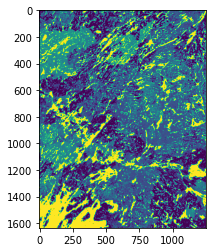

In [61]:
#Open data with rasterio
img = rasterio.open(data_path)
show(img, 0)

In [62]:
#Read the image
array = img.read()

#Create numpy array
array = np.array(array)

#Check shape
array.shape

(1, 1635, 1250)

In [63]:
#Read NRCAN raster to dataframe
nrcann = raster_to_dataframe(data_path)
nrcann.head()

,Band_1
0,1
1,1
2,1
3,1
4,5


In [64]:
#Rename column
nrcann = nrcann.rename(columns={'Band_1':'Class'})

#Print sum of classification types
print('Number of NRCANN Classes: ', nrcann.Class.nunique())

#Check which classifications are listed
print(nrcann.Class.value_counts())

Number of NRCANN Classes:  10
1     672677
18    518343
5     347911
8     286962
6     118658
10     79017
14     14771
16      3552
17      1785
2         74
Name: Class, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


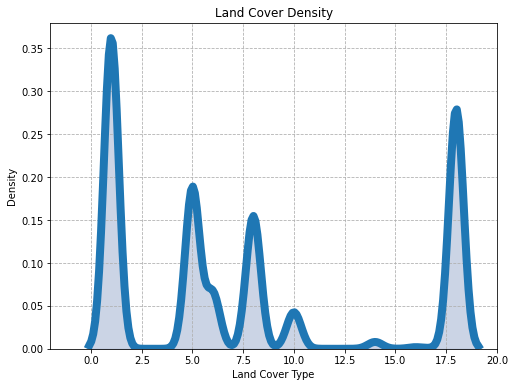

In [65]:
#Plot Class distribution
plt.figure(figsize=[8,6])
plt.grid(linestyle='--')
dp = sns.distplot(nrcann.Class, hist=False, kde_kws=dict(linewidth=8))
l1 = dp.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
dp.fill_between(x1,y1, color="#5471ab", alpha=0.3)
dp.set_xlim(-2, 20)
dp.set_xlabel("Land Cover Type")
dp.set_title("Land Cover Density")

#Save
fig = dp.get_figure()
fig.savefig('/content/drive/MyDrive/saskatchewan_classes.png')

In [66]:
#Double check shapes
data.shape, nrcann.shape

((2043750, 12), (2043750, 1))

In [67]:
#Merge nrcann with data
new_data = pd.concat([data, nrcann], axis = 1)
new_data.head()

,B08,B02,B07,B03,B11,B05,B09,B01,B06,B8A,B12,B04,Class
0,0.1452,0.0130,0.1358,0.0302,0.0890,0.0560,0.1626,0.0133,0.1212,0.1500,0.0464,0.0237,1
1,0.1373,0.0102,0.1284,0.0291,0.0755,0.0512,0.1567,0.0145,0.1182,0.1427,0.0366,0.0194,1
2,0.1323,0.0115,0.1232,0.0282,0.0892,0.0499,0.1580,0.0160,0.1076,0.1366,0.0457,0.0212,1
3,0.1644,0.0216,0.1411,0.0393,0.1579,0.0795,0.1474,0.0164,0.1232,0.1722,0.0877,0.0417,1
4,0.1266,0.0162,0.1193,0.0336,0.1088,0.0626,0.1477,0.0140,0.1104,0.1327,0.0598,0.0294,5


In [68]:
#Save merged data
new_data.to_csv('/content/drive/MyDrive/AISC/saskatchewan_data.csv', index = False)